# Poisson vs. gaussian regression
> How do the two models compare in terms of accuracy at different read counts?

In [7]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

plt.rc("font", size=20)

In [9]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [10]:
# Copied from scaling_experiment_matrix.ipynb


def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances

In [16]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)

results = pd.DataFrame(
    columns=[
        "loss_fn",
        "genome",
        "sample",
        "scale",
        "true_ptr",
        "inferred_ptr",
        "inferred_abundance",
        "abundance",
        "ptr_score",
        "abundance_score",
        "n_reads",
    ]
)

losses = [torch.nn.MSELoss(), torch.nn.PoissonNLLLoss(log_input=False)]
for multiplier in range(-3, 3):
    scale = 10**multiplier
    print(scale)
    abundances, log2_ptrs, otus = make_tables(
        n_genomes=10,
        n_samples=20,  # same number of samples for each
        db=rnadb,
        sparsity=0,
        multiplier=scale,
    )
    for loss_fn, normalize in zip(losses, [True, False]):
        solver = TorchSolver(otus=otus, db=rnadb, normalize=normalize)
        solver.train(lr=0.1, clip=True, model_bias=False, loss_fn=loss_fn)
        B_scores, A_scores, B_inf, A_inf = score(
            solver=solver,
            true_log2_ptrs=log2_ptrs,
            true_abundances=abundances,
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    # results = results.append(
                    results.loc[len(results)] = {
                        "loss_fn": loss_fn,
                        "genome": genome_id,
                        "sample": sample_id,
                        "scale": scale,
                        "true_ptr": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "inferred_ptr": B_inf.loc[genome_id, sample_id],
                        "inferred_abundance": A_inf.loc[genome_id, sample_id],
                        "abundance": abundances.loc[genome_id, sample_id],
                        "ptr_score": B_scores.loc[genome_id, sample_id],
                        "abundance_score": A_scores.loc[genome_id, sample_id],
                        "n_reads": otus.loc[rnadb[genome_id]["md5"].unique(), sample_id].sum(),
                    }
                    # },
                    # ignore_index=True,
                    # )
                except KeyError as e:
                    print(f"=====KEY ERROR: {e}")

0.001
Using OTU index for md5s
Initial:	 2.4472720623016357
Epoch 0:	 0.0019348586210981011
Epoch 1:	 0.0019348571076989174
Epoch 2:	 0.0019349815556779504
Epoch 3:	 0.0019348555942997336
Epoch 4:	 0.0019348602509126067
Epoch 5:	 0.0019348559435456991
Epoch 6:	 0.0019348821369931102
Epoch 7:	 0.001934861415065825
Epoch 8:	 0.0019348692148923874
Epoch 9:	 0.0019348586210981011
Using OTU index for md5s
Initial:	 1.048128604888916
Epoch 0:	 0.36051979660987854
Epoch 1:	 0.3605203628540039
Epoch 2:	 0.3605199456214905
Epoch 3:	 0.360520601272583
Epoch 4:	 0.3605285882949829
Epoch 5:	 0.3605228066444397
Epoch 6:	 0.3605222702026367
0.01
Using OTU index for md5s
Initial:	 5.072357654571533
Epoch 0:	 0.0001389895478496328
Epoch 1:	 0.00013898489123675972
Epoch 2:	 0.00013900046178605407
Epoch 3:	 0.00013898481847718358
Epoch 4:	 0.00013898756878916174
Epoch 5:	 0.00013898486213292927
Epoch 6:	 0.00013899766781833023
Epoch 7:	 0.00013903490616939962
Epoch 8:	 0.00013898608449380845
Epoch 9:	 0

In [18]:
# Save results

results.to_csv("../../data/figures/poisson_vs_gaussian_scaling.tsv", index=False, sep="\t")

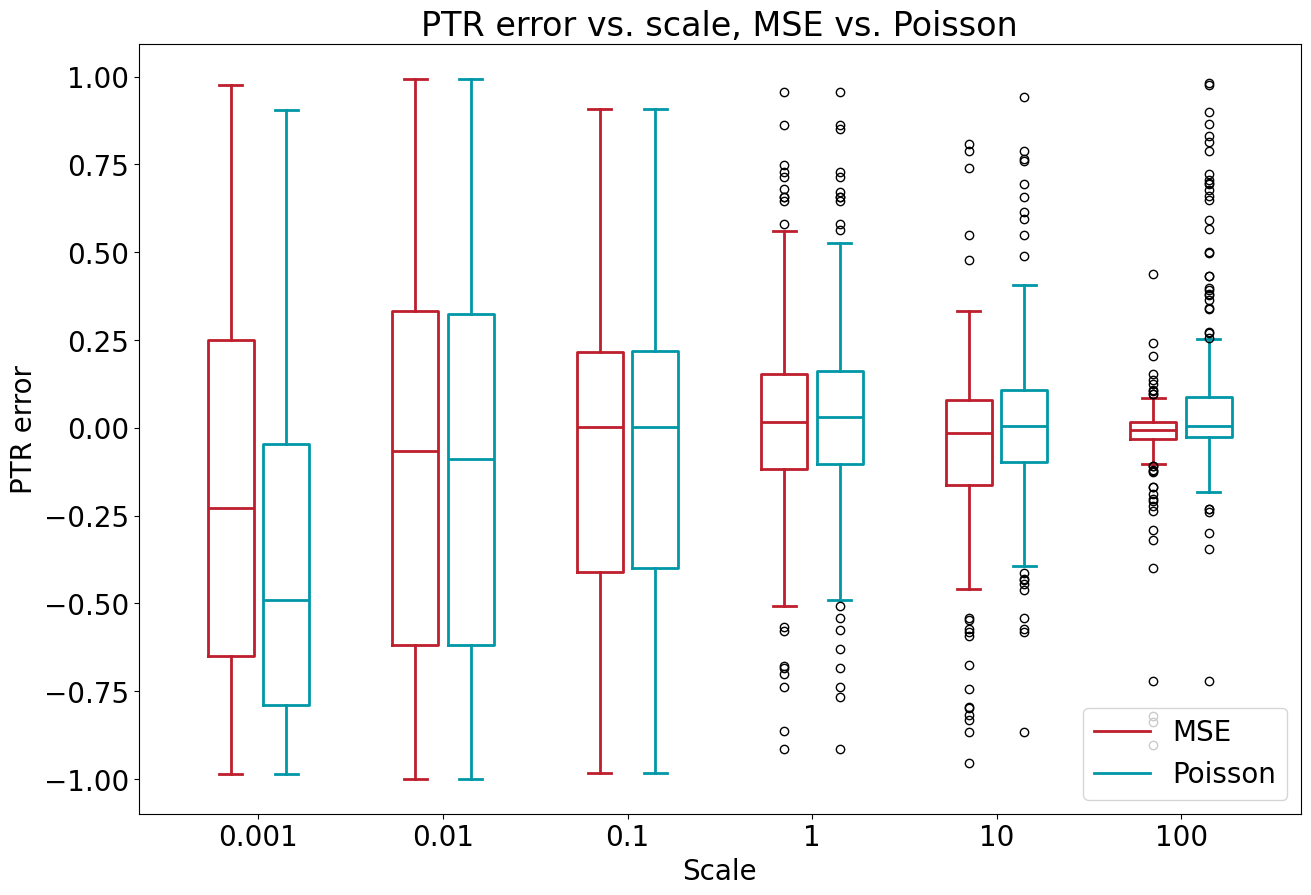

In [19]:
fig = plt.figure(figsize=(15, 10))

# Make data
for_boxplot_mse = results[results["loss_fn"] == losses[0]]
for_boxplot_poisson = results[results["loss_fn"] == losses[1]]
x1 = [for_boxplot_mse[for_boxplot_mse["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_poisson[for_boxplot_poisson["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["MSE", "Poisson"])